In [1]:
import os
import pandas as pd
import numpy as np
import math
import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'

In [3]:
sma = lambda x, y: x.rolling(int(y)).mean()

ewma = lambda x, y: x.ewm(span=y).mean()

def s(x,x0,x1,y0=0,y1=1,d=np.nan):
    if x>=x1:
        return y1
    if x<x0:
        return y0
    return d

In [4]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)

price = price.apply(math.log)

true_ret = price.pct_change()
true_yret = empy.aggregate_returns(true_ret, convert_to='yearly')
true_mret = empy.aggregate_returns(true_ret, convert_to='monthly')

In [68]:
true_up = (true_ret>=0).astype(int)

<AxesSubplot:xlabel='date'>

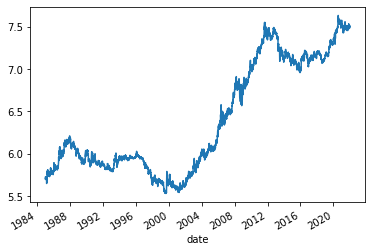

In [5]:
price[start:end].plot()
# plt.show()
# true_mret.plot()
# plt.show()
# true_yret.plot()

<AxesSubplot:>

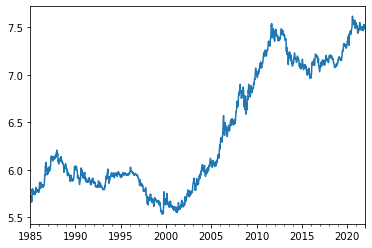

In [6]:
period_index = price.index.to_period('W')
weeklyprice = price.groupby(period_index).nth(-1)
weeklyprice.index = [idx.end_time.date() for idx in weeklyprice.index]
weeklyprice.index = pd.to_datetime(weeklyprice.index)
weeklyprice[start:end].plot()

In [7]:
ll = [34 + n*8 for n in range(0, 8)]
ll.sort()
sma_all = {'ema{}'.format(span): ewma(weeklyprice.shift(), span) for span in ll}
sma_all = pd.DataFrame(sma_all).dropna()
sma_all

,ema34,ema42,ema50,ema58,ema66,ema74,ema82,ema90
1980-01-06,6.238325,6.238325,6.238325,6.238325,6.238325,6.238325,6.238325,6.238325
1980-01-13,6.348533,6.347933,6.347525,6.347230,6.347006,6.346831,6.346690,6.346573
1980-01-20,6.378907,6.378190,6.377700,6.377345,6.377075,6.376863,6.376692,6.376552
1980-01-27,6.473872,6.471833,6.470448,6.469445,6.468685,6.468090,6.467611,6.467217
1980-02-03,6.480691,6.478957,6.477768,6.476902,6.476244,6.475726,6.475309,6.474965
...,...,...,...,...,...,...,...,...
2022-01-16,7.495340,7.494542,7.492641,7.489567,7.485442,7.480461,7.474827,7.468725
2022-01-23,7.495896,7.495031,7.493128,7.490093,7.486028,7.481117,7.475555,7.469523
2022-01-30,7.496921,7.495906,7.493941,7.490898,7.486858,7.481990,7.476478,7.470497
2022-02-06,7.496557,7.495657,7.493807,7.490886,7.486968,7.482218,7.476817,7.470938


<AxesSubplot:>

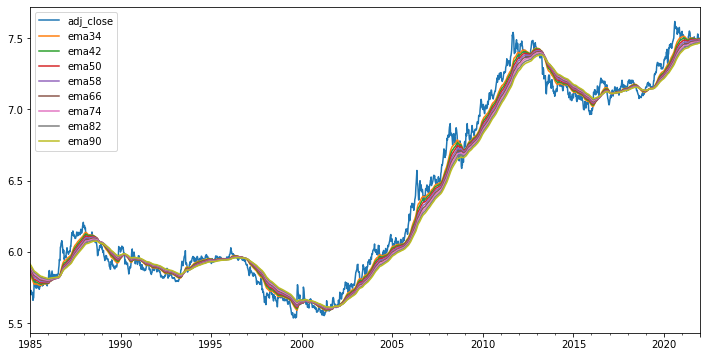

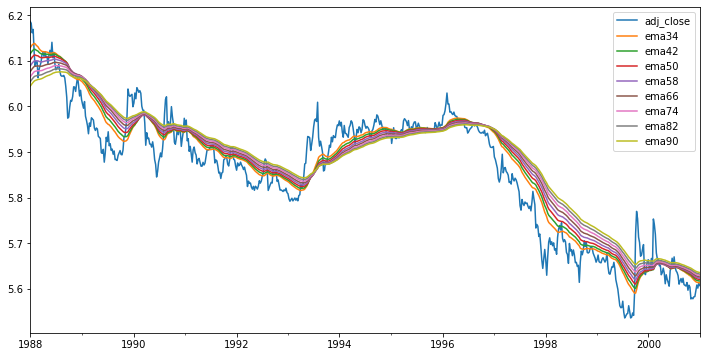

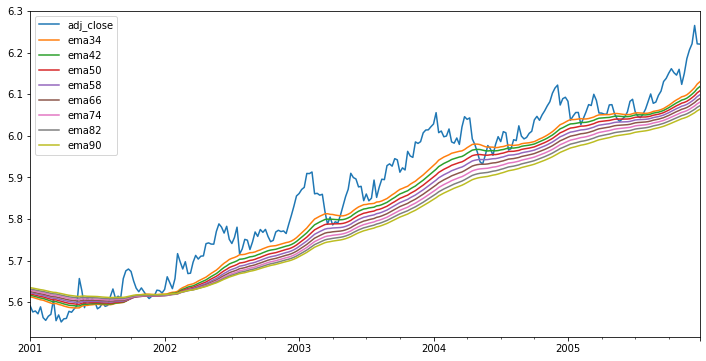

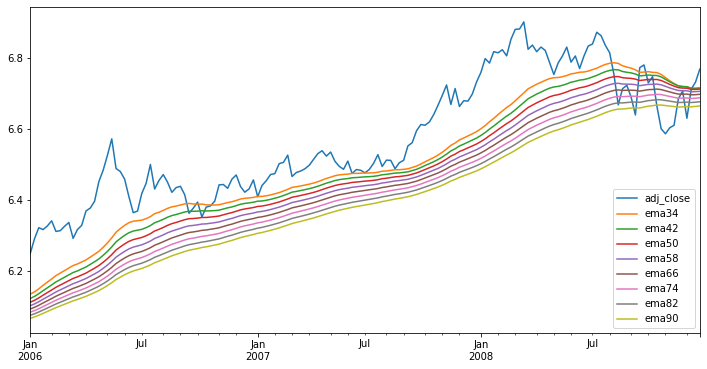

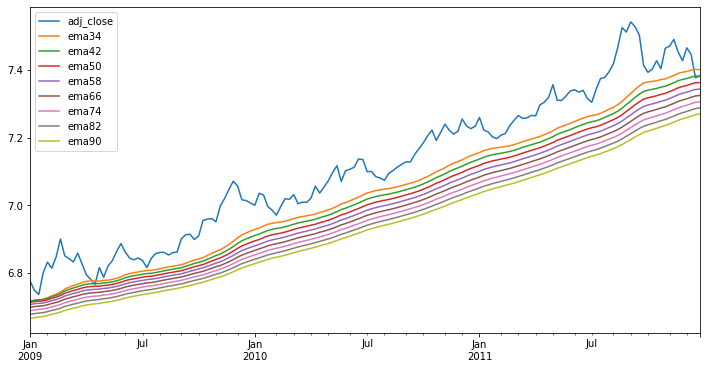

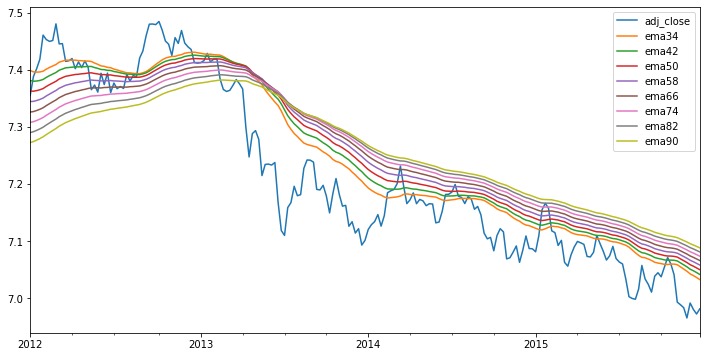

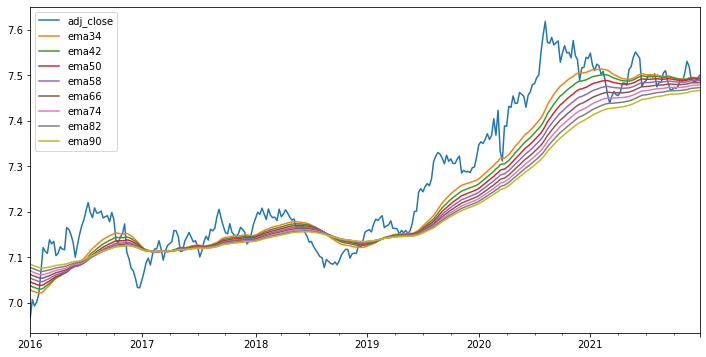

In [8]:
polt_sma_df = pd.concat([weeklyprice, sma_all], axis=1)
polt_sma_df[start:end].plot(figsize=(12,6))
polt_sma_df['1988':'2000'].plot(figsize=(12,6))
polt_sma_df['2001':'2005'].plot(figsize=(12,6))
polt_sma_df['2006':'2008'].plot(figsize=(12,6))
polt_sma_df['2009':'2011'].plot(figsize=(12,6))
polt_sma_df['2012':'2015'].plot(figsize=(12,6))
polt_sma_df['2016':'2021'].plot(figsize=(12,6))

In [9]:
import itertools
t = list(sma_all.columns)
c = list(itertools.combinations(t, 2))
pairs = list(set(c))
pairs.sort()
# pairs

In [10]:
def plot_with_flip(df, flip_df, sma_baseline, cont_min=4*6):
    maxvalue = df.max().max()
    minvalue = df.min().min()

    fig, ax = plt.subplots(figsize=(12,6))
    df.plot(ax=ax)
    previous_loc = None
    count_cont = 0
    for idx in flip_df.index:
        # print("==================================================")
        # print(idx, flip_df[idx], previous_loc)
        if flip_df[idx] or idx == flip_df.index[-1]:
            # plt.vlines(idx, minvalue, maxvalue)
        
            if previous_loc is None:
                previous_loc = (idx, sma_baseline[idx])
            else:
                current_loc = sma_baseline[idx]

                if count_cont >= cont_min:
                    if previous_loc[1] < current_loc:
                        facecolor ='green'
                    else:
                        facecolor ='red'
                    # print("        previous_loc: ", previous_loc)
                    # print("        current_loc: ", idx, current_loc)
                    # print("        facecolor: ", facecolor)
                    ax.axvspan(previous_loc[0], idx, alpha=0.5, color=facecolor)
                count_cont = 0
                previous_loc = (idx, current_loc)
        else:
            count_cont += 1
            if previous_loc is None:
                previous_loc = (idx, sma_baseline[idx])


    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
flip_df = pd.DataFrame()
for a, b in pairs:
    x = sma_all[a]
    y = sma_all[b]
    diff = x - y
    diff_signal = (diff>0).astype(int)
    flip_df["{}_{}".format(a, b)] = (diff_signal != diff_signal.shift()).dropna()
flip_df

In [ ]:
cont_min = 48

polt_sma_df = pd.concat([weeklyprice, sma_all], axis=1)
cross_any = flip_df.any(axis=1)
# cc = pd.concat([cross_any, cross_any != cross_any.shift()], axis=1)
# cc_flip = cc.all(axis=1)

plot_with_flip(polt_sma_df[start:end], cross_any[start:end], sma_all['ema34'], cont_min)
plot_with_flip(polt_sma_df['1988':'2000'], cross_any['1988':'2000'], sma_all['ema34'], cont_min)
plot_with_flip(polt_sma_df['2001':'2005'], cross_any['2001':'2005'], sma_all['ema34'], cont_min)
plot_with_flip(polt_sma_df['2006':'2008'], cross_any['2006':'2008'], sma_all['ema34'], cont_min)
plot_with_flip(polt_sma_df['2009':'2011'], cross_any['2009':'2011'], sma_all['ema34'], cont_min)
plot_with_flip(polt_sma_df['2012':'2015'], cross_any['2012':'2015'], sma_all['ema34'], cont_min)
plot_with_flip(polt_sma_df['2016':'2021'], cross_any['2016':'2021'], sma_all['ema34'], cont_min)


for i in range(int(start), int(end)):
    plot_with_flip(polt_sma_df[str(i)], cross_any[str(i)], sma_all['ema34'], cont_min)

In [14]:
weekly_ret = weeklyprice.pct_change()
weekly_up = (weekly_ret >= 0).astype(int)

In [37]:
lookback = 24
rollback_cross_D1_5 = cross_any.rolling(lookback).apply(lambda x: not x.any())
rollback_cross_D1_5.name = 'phase15_lookback{}W'.format(lookback)
# rollback_cross_D1_5

In [38]:
sma_trend = sma_all.pct_change(lookback)
sma_trend = (sma_trend>=0).all(axis=1)
#.apply(lambda x: not x.any())
# sma_trend['2008-08':'2008-12']

In [39]:
# rollback_cross_D1_5
filter_D1_5 = pd.Series(np.nan, index=rollback_cross_D1_5.index)
filter_D1_5.name = rollback_cross_D1_5.name
# cross_period = rollback_cross_D1_5.index[rollback_cross_D1_5!=1]
# filter_D1_5[cross_period] = np.nan

parallel_period = rollback_cross_D1_5.index[rollback_cross_D1_5==1]
parallel_sma_trend = sma_trend[parallel_period]
parallel_up_period = parallel_sma_trend.index[parallel_sma_trend==1]
parallel_down_period = parallel_sma_trend.index[parallel_sma_trend==0]

filter_D1_5[parallel_up_period] = 5
filter_D1_5[parallel_down_period] = 1

# filter_D1_5['2008-08':'2008-12']
# pd.Series(index=parallel_period)['2008-08':'2008-12']

In [40]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

In [41]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se

In [42]:
def print_all_result(ret_df, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        strategy_list_sel = strategy_list_sel[-topn:]

    if 'buy_and_hold' in strategy_list_sel:
        strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = ['buy_and_hold']
    if base_case is not None:
        for bc in base_case:
            if bc == 'buy_and_hold':
                continue
            else:
                if bc not in strategy_list_sel:
                    base_list.append(bc)
    strategy_list_sel = base_list+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(20,15))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    base_cumret = (1+ret_df['buy_and_hold']).cumprod().apply(math.log)
    base_cumret.name = 'buy_and_hold'
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
#         try:
        if True:
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(figsize=(20,15))
            ax = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )
            base_cumret.plot(ax=ax)

            ax.set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax.get_legend()#.remove()
#             ax.set_yscale("log")
            ax.figure.colorbar(sm_prob)
            ax.set_title("{} {}".format(case, plot_hue))
            plt.show()
            
            fig, ax = plt.subplots(figsize=(12,10))
            proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax, legend=False)
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(case + ' proba')
            plt.show()
#         except Exception as e:
#             print(e)
#             continue
    
    
    return strategy_list_sel
    

In [43]:
# true_ret_3stage = pd.cut(weekly_up, bins=[0, 0.3, 0.6, 1], right=True, labels=False).fillna(0)(weekly_up >= 0).astype(int)

bins=[0, 0.4, 0.6, 1]

true_yret_roll_vote_pred = pd.DataFrame(index=weekly_up.index)
true_yret_roll_vote_proba = pd.DataFrame(index=weekly_up.index)
lookbacks = [3, 4, 5, 10, 12, 15, 24, 48]
for lookback in lookbacks:
    true_yret_rollN = weekly_up.shift().rolling(lookback).mean()
    true_yret_rollN.name = 'phase234_lookback{}W_vote'.format(lookback)
    true_yret_roll_vote_proba = pd.concat([true_yret_roll_vote_proba, true_yret_rollN], axis=1)

    pp = pd.cut(true_yret_rollN, bins=bins, right=True, labels=False).fillna(0)
    pp.name = 'phase234_lookback{}W_vote'.format(lookback)
    true_yret_roll_vote_pred = pd.concat([true_yret_roll_vote_pred, pp], axis=1)

true_yret_roll_vote_proba = true_yret_roll_vote_proba.shift().dropna()
true_yret_roll_vote_pred = true_yret_roll_vote_pred.shift().dropna()
true_yret_roll_vote_pred = true_yret_roll_vote_pred + 2

# true_yret_roll_vote_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_vote_pred.index])
# true_yret_roll_vote_proba.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_vote_proba.index])
# true_yret_roll_vote_proba

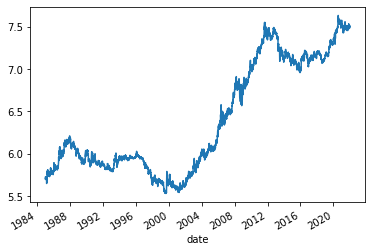

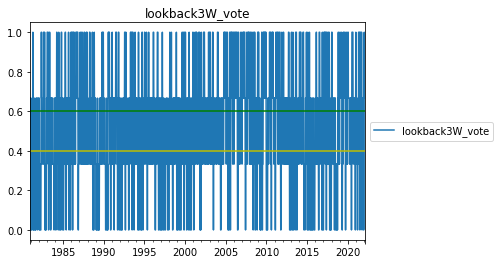

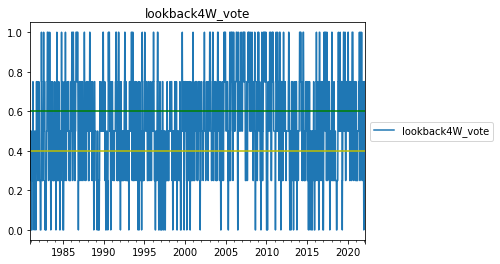

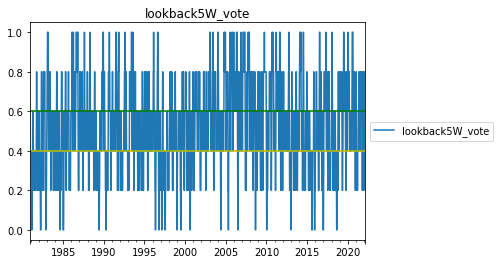

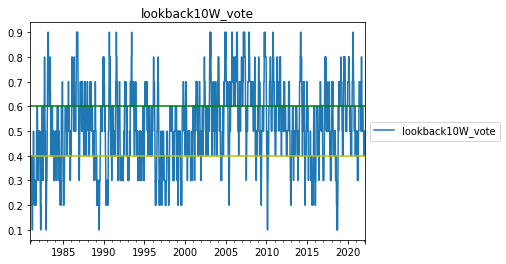

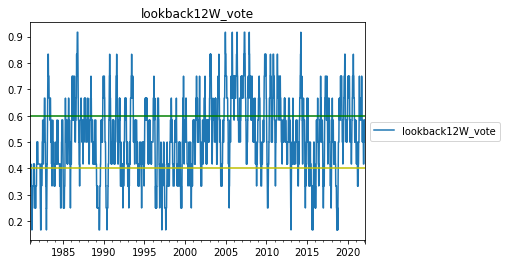

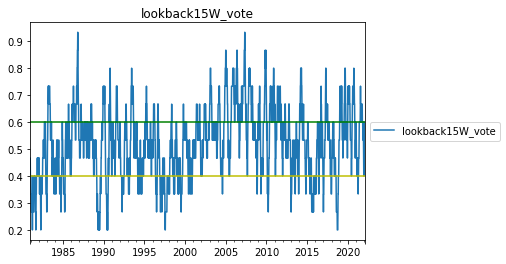

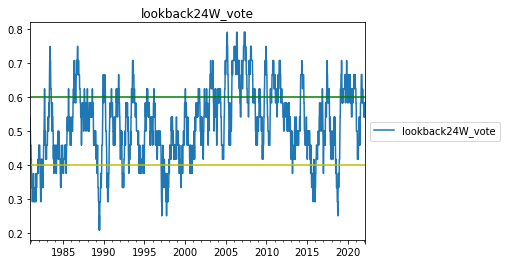

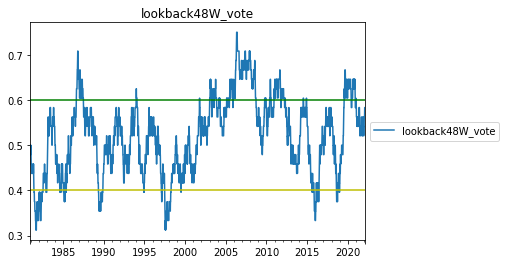

In [33]:
price[start:end].plot()
plt.show()

# bounds = pd.DataFrame([[0.5, 0.55]] * len(tt.index), index=tt.index, columns=['lower', 'upper'])
# true_yret_roll_vote_proba.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.hlines(y = 0.5, xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="lower", color='y')
# plt.hlines(y = 0.55, xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="upper", color='g')
# plt.show()

for col in true_yret_roll_vote_proba.columns:
    tt = true_yret_roll_vote_proba[col]
    tt.plot(title=col).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.hlines(y = bins[1], xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="lower", color='y')
    plt.hlines(y = bins[2], xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="upper", color='g')
    plt.show()

In [44]:
rollback_cross = pd.DataFrame()
for col in true_yret_roll_vote_pred.columns:
    tmp = pd.concat([true_yret_roll_vote_pred[col], filter_D1_5], axis=1)
    tmp = tmp.fillna(method='ffill', axis=1)
    rollback_cross["{}_{}".format(filter_D1_5.name, col)] = tmp.iloc[:, -1]
# rollback_cross

In [45]:
def plot_with_flip_5stages(df, rollback_cross):
    maxvalue = df.max().max()
    minvalue = df.min().min()

    facecolor_map = {
        1: 'red',
        2: 'yellow',
        3: 'c',
        4: 'g',
        5: 'lime'
    }

    
    count_cont = 0
    for case in rollback_cross.columns:
        # print("==================================================")
        # print(idx, flip_df[idx], previous_loc)
        stage_ser = rollback_cross[case]

        fig, ax = plt.subplots(figsize=(12,6))
        df.plot(ax=ax)

        previous_stage = None
        for idx in stage_ser.index:
            if previous_stage is None:
                previous_stage = stage_ser[idx]
                baseline_loc = idx
                continue

            current_stage = stage_ser[idx]
            if idx == stage_ser.index[-1]:
                facecolor = facecolor_map[current_stage]
                ax.axvspan(baseline_loc, idx, alpha=0.5, color=facecolor)
                continue

            if current_stage == previous_stage:
                continue
            else:
                facecolor = facecolor_map[previous_stage]
                ax.axvspan(baseline_loc, idx, alpha=0.5, color=facecolor)
                previous_stage = current_stage
                baseline_loc = idx
        ax.set_title(case)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

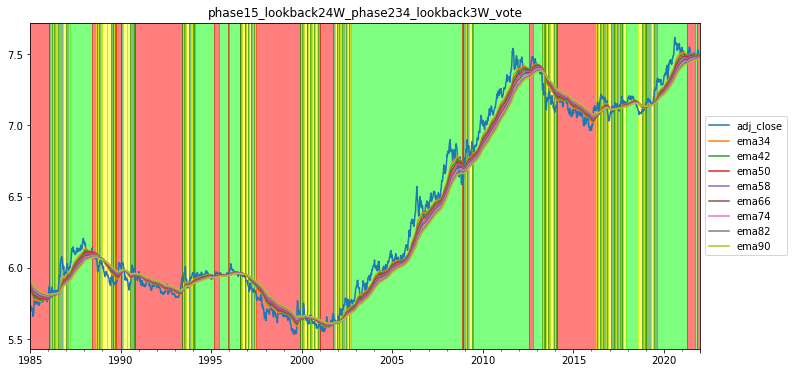

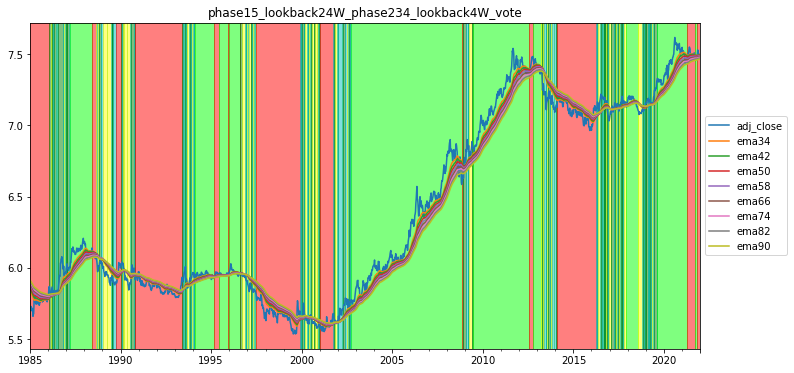

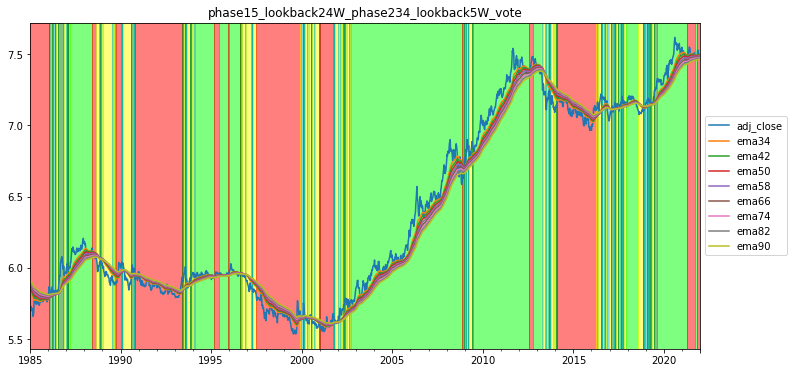

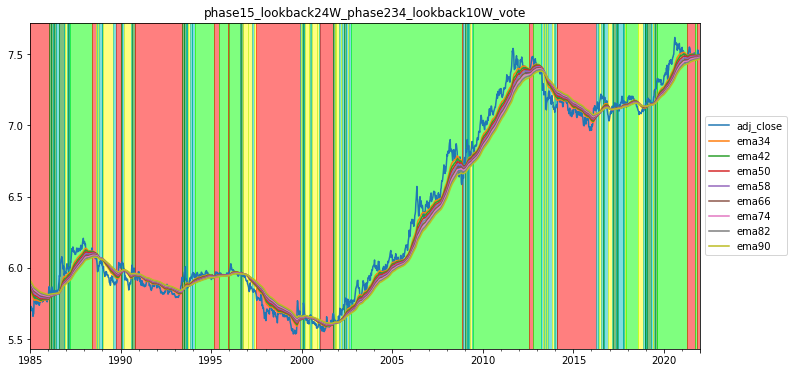

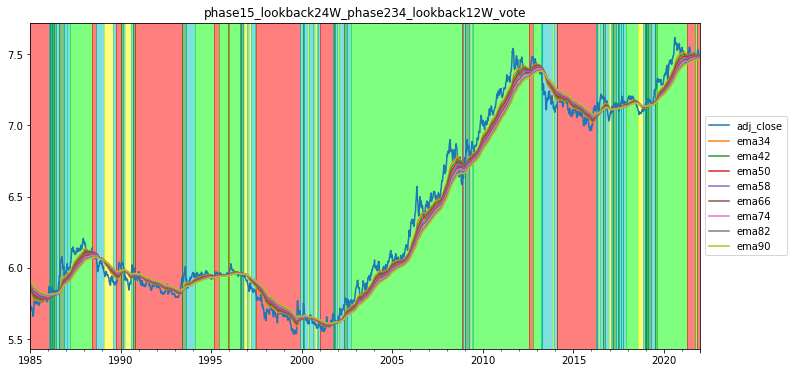

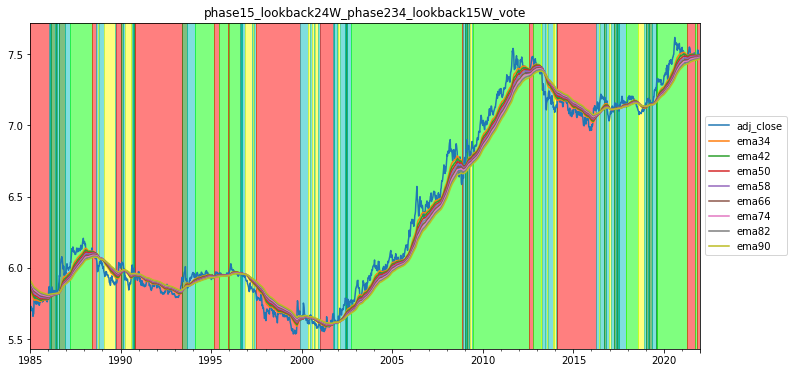

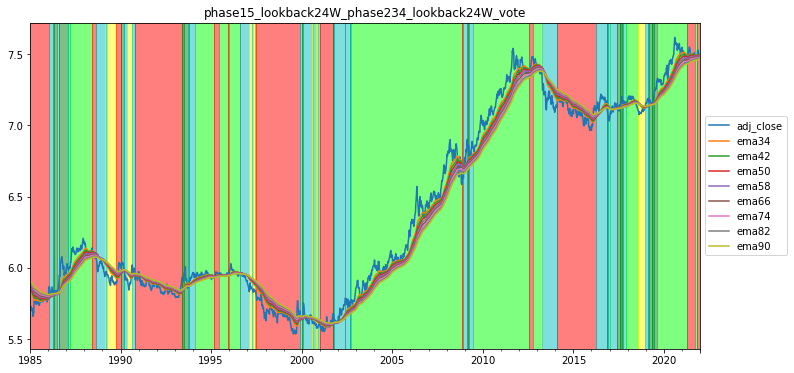

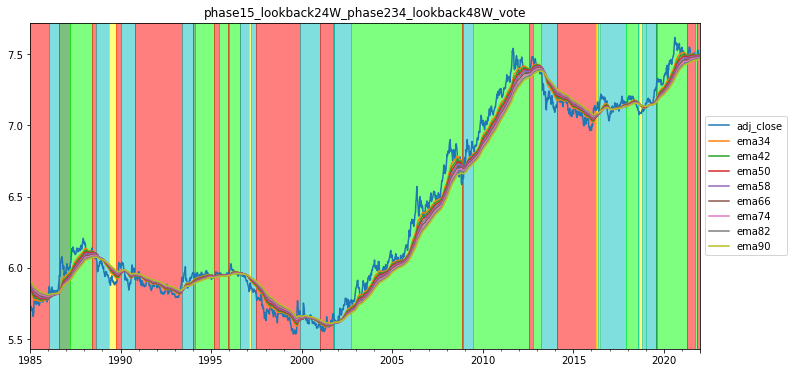

In [46]:
plot_with_flip_5stages(polt_sma_df[start:end], rollback_cross[start:end])

In [28]:
"""plot_with_flip_5stages(polt_sma_df[start:end], rollback_cross[start:end])
plot_with_flip_5stages(polt_sma_df['1988':'2000'], rollback_cross['1988':'2000'])
plot_with_flip_5stages(polt_sma_df['2001':'2005'], rollback_cross['2001':'2005'])
plot_with_flip_5stages(polt_sma_df['2006':'2008'], rollback_cross['2006':'2008'])
plot_with_flip_5stages(polt_sma_df['2009':'2011'], rollback_cross['2009':'2011'])
plot_with_flip_5stages(polt_sma_df['2012':'2015'], rollback_cross['2012':'2015'])
plot_with_flip_5stages(polt_sma_df['2016':'2021'], rollback_cross['2016':'2021'])


for i in range(int(start), int(end)):
    plot_with_flip_5stages(polt_sma_df[str(i)], rollback_cross[str(i)])"""

"plot_with_flip_5stages(polt_sma_df[start:end], rollback_cross[start:end])\nplot_with_flip_5stages(polt_sma_df['1988':'2000'], rollback_cross['1988':'2000'])\nplot_with_flip_5stages(polt_sma_df['2001':'2005'], rollback_cross['2001':'2005'])\nplot_with_flip_5stages(polt_sma_df['2006':'2008'], rollback_cross['2006':'2008'])\nplot_with_flip_5stages(polt_sma_df['2009':'2011'], rollback_cross['2009':'2011'])\nplot_with_flip_5stages(polt_sma_df['2012':'2015'], rollback_cross['2012':'2015'])\nplot_with_flip_5stages(polt_sma_df['2016':'2021'], rollback_cross['2016':'2021'])\n\n\nfor i in range(int(start), int(end)):\n    plot_with_flip_5stages(polt_sma_df[str(i)], rollback_cross[str(i)])"

In [56]:
preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
preds = pd.concat([preds, rollback_cross], axis=1)
preds = preds.fillna(method='ffill')
preds = preds.loc[true_ret.index, :]
# preds = preds['1994': end]
# preds.shape
preds.shape

(10921, 9)

In [71]:
buy_preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
for case in rollback_cross.columns:
    for i in range(2, 6):
        buy_preds["{}_buy>={}".format(case, i)] = (preds[case] >= i).astype(int)
buy_preds = buy_preds[start:end]
buy_preds.shape

(9612, 33)

In [72]:
ret_sma_cross = buy_preds.multiply(true_ret[start:end], 0)
ret_sma_cross.shape

(9612, 33)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
phase15_lookback24W_phase234_lookback48W_vote_buy>=3,0.679671,0.018520,0.511860,0.521200,1.240611
phase15_lookback24W_phase234_lookback15W_vote_buy>=3,0.624740,0.019977,0.514565,0.525229,1.241256
phase15_lookback24W_phase234_lookback24W_vote_buy>=3,0.656991,0.019353,0.513941,0.523515,1.240526
phase15_lookback24W_phase234_lookback12W_vote_buy>=3,0.651165,0.020393,0.512901,0.522927,1.240202
phase15_lookback24W_phase234_lookback5W_vote_buy>=2,0.702039,0.018520,0.511132,0.520006,1.238832
phase15_lookback24W_phase234_lookback3W_vote_buy>=2,0.702039,0.018520,0.511132,0.520006,1.238832
phase15_lookback24W_phase234_lookback12W_vote_buy>=2,0.702039,0.018520,0.511132,0.520006,1.238832
phase15_lookback24W_phase234_lookback15W_vote_buy>=2,0.702039,0.018520,0.511132,0.520006,1.238832
phase15_lookback24W_phase234_lookback4W_vote_buy>=2,0.702039,0.018520,0.511132,0.520006,1.238832
phase15_lookback24W_phase234_lookback48W_vote_buy>=2,0.702039,0.018520,0.511132,0.520006,1.238832


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.007117,0.304822,-0.109400,-0.040918,0.173929
phase15_lookback24W_phase234_lookback48W_vote_buy>=3,0.005353,0.270964,-0.100772,-0.044270,0.120928
phase15_lookback24W_phase234_lookback15W_vote_buy>=3,0.005240,0.272537,-0.087671,-0.041582,0.126026
phase15_lookback24W_phase234_lookback24W_vote_buy>=3,0.005373,0.273754,-0.106439,-0.047378,0.113405
phase15_lookback24W_phase234_lookback12W_vote_buy>=3,0.005437,0.278079,-0.081016,-0.038645,0.140702
phase15_lookback24W_phase234_lookback5W_vote_buy>=2,0.005692,0.283894,-0.101712,-0.044015,0.129313
phase15_lookback24W_phase234_lookback3W_vote_buy>=2,0.005692,0.283894,-0.101712,-0.044015,0.129313
phase15_lookback24W_phase234_lookback12W_vote_buy>=2,0.005692,0.283894,-0.101712,-0.044015,0.129313
phase15_lookback24W_phase234_lookback15W_vote_buy>=2,0.005692,0.283894,-0.101712,-0.044015,0.129313
phase15_lookback24W_phase234_lookback4W_vote_buy>=2,0.005692,0.283894,-0.101712,-0.044015,0.129313


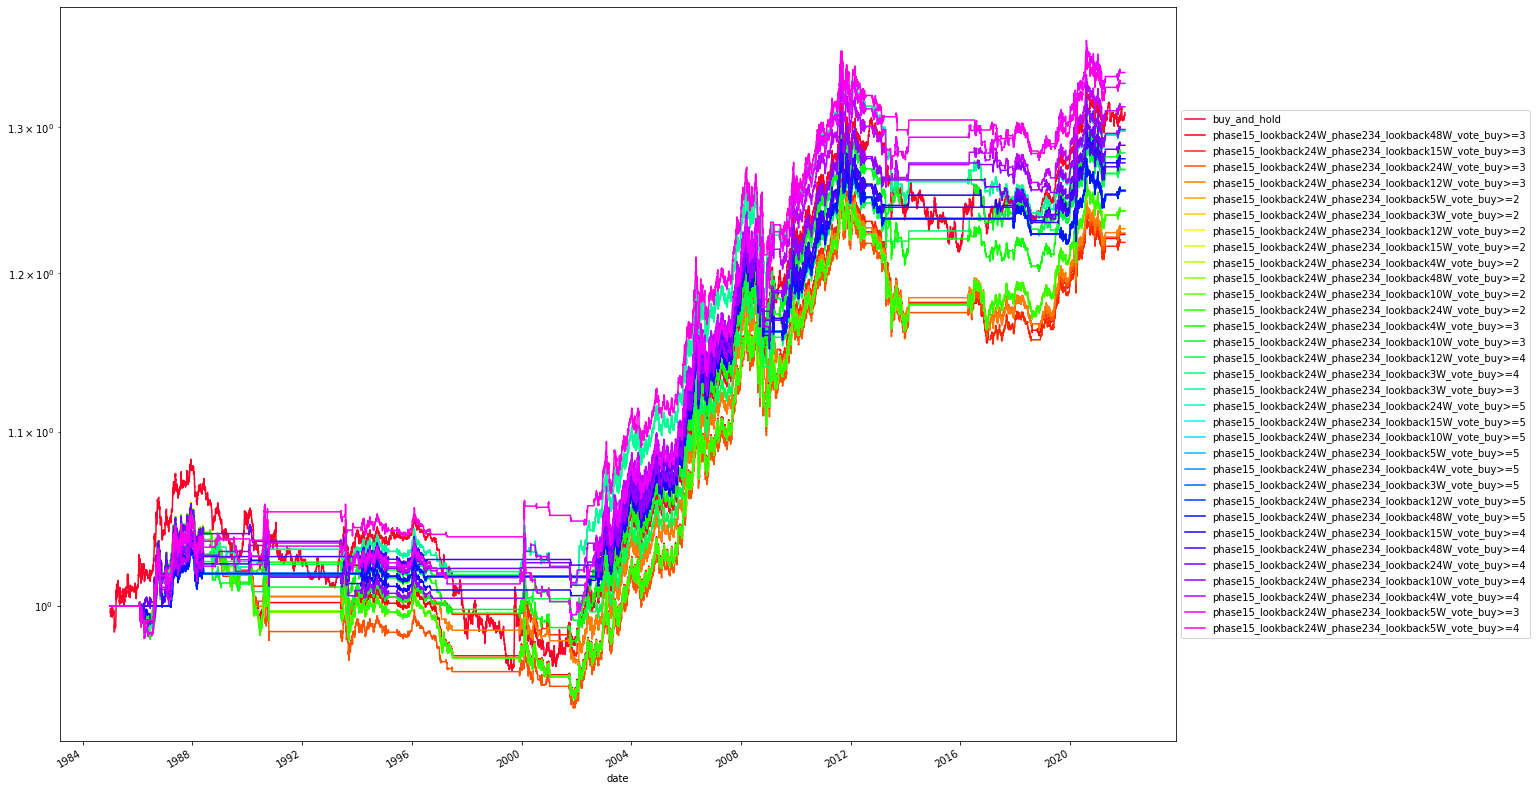

In [73]:
strategy_list_sel = print_all_result(ret_sma_cross, topn=len(ret_sma_cross.columns))

In [29]:
# true_yret_roll_vote_pred
# true_yret_up

acc = pd.Series(index=true_yret_roll_vote_pred.columns)
for col in true_yret_roll_vote_pred.columns:
    acc[col] = accuracy_score(true_yret_up[true_yret_roll_vote_pred.index], true_yret_roll_vote_pred[col])
acc

NameError: name 'true_yret_up' is not defined

In [ ]:
true_ret_roll_vote_proba = pd.DataFrame()
lookbacks = [1, 2, 3, 5, 8, 10, 15]
for lookback in lookbacks:
    true_yret_rollN = true_up.astype(int).rolling(lookback*252).mean()
    true_yret_rollN.name = 'lookback{}Y_vote'.format(lookback)
    # print("================================\n", true_yret_rollN)
    true_ret_roll_vote_proba = pd.concat([true_ret_roll_vote_proba, true_yret_rollN], axis=1)

true_ret_roll_vote_proba = true_ret_roll_vote_proba.dropna()
true_ret_roll_vote_proba

In [ ]:
total_return = lambda x: (1+x).prod()-1
true_ret.name = 'true_ret'

lookbacks = [1, 2, 3, 5, 8, 10, 15]
true_yret_roll_ret = pd.DataFrame()
for lookback in lookbacks:
    true_yret_rollN = true_ret.rolling(lookback*252).apply(total_return)
    true_yret_rollN.name = 'lookback{}Y_ret'.format(lookback)
    true_yret_roll_ret = pd.concat([true_yret_roll_ret, true_yret_rollN], axis=1)
true_yret_roll_ret = true_yret_roll_ret.dropna()
true_yret_roll_ret_pred = (true_yret_roll_ret > 0).astype(int).shift().dropna()
# true_yret_roll_ret_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_ret_pred.index])
true_yret_roll_ret_pred

In [ ]:
price[true_yret_roll_ret.index].plot()
plt.show()

for col in true_yret_roll_ret.columns:
    tt = true_yret_roll_ret[col]
    tt.plot(title=col)
    plt.show()

In [ ]:
total_return = lambda x: (1+x).prod()-1
true_yret.name = 'true'

lookbacks = [1, 2, 3, 5, 8, 10, 15]
true_yret_roll_ret = pd.DataFrame()
for lookback in lookbacks:
    true_yret_rollN = true_yret.rolling(lookback).apply(total_return)
    true_yret_rollN.name = 'lookback{}Y_ret'.format(lookback)
    true_yret_roll_ret = pd.concat([true_yret_roll_ret, true_yret_rollN], axis=1)
true_yret_roll_ret = true_yret_roll_ret.dropna()
true_yret_roll_ret_pred = (true_yret_roll_ret > 0).astype(int).shift().dropna()
true_yret_roll_ret_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_ret_pred.index])
true_yret_roll_ret_pred

In [ ]:
preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
preds = pd.concat([preds, true_yret_roll_ret_pred, true_yret_roll_vote_pred], axis=1)
preds = preds.fillna(method='ffill')
preds = preds.loc[true_ret.index, :]
preds = preds['1994': end]
preds.shape

In [ ]:
ret_sma_cross = preds.multiply(true_ret[preds.index], 0)
ret_sma_cross.shape

In [ ]:
strategy_list_sel = print_all_result(ret_sma_cross)